### Data Preparation

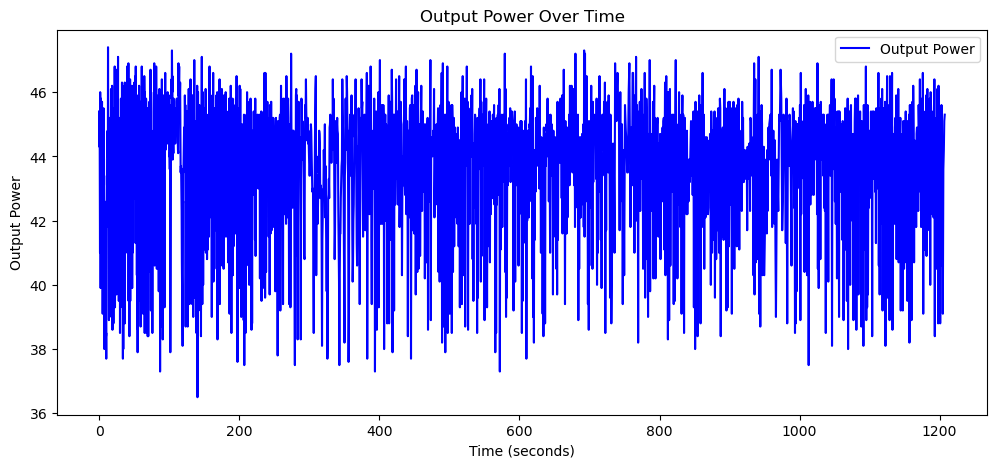

⚠️ ERROR: Data terlalu sedikit untuk 2900 langkah! Coba kurangi `past_steps` atau `future_steps`.
✅ X shape: (0,), y shape: (0,)
Training Data: (402, 1000, 1), Testing Data: (101, 1000, 1)
Epoch 1/50


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 184s 12s/step - loss: 0.3892 - val_loss: 0.0396
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0613 - val_loss: 0.0494
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0422 - val_loss: 0.0374
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0377 - val_loss: 0.0373
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0375 - val_loss: 0.0375
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0372 - val_loss: 0.0371
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0372 - val_loss: 0.0371
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0372 - val_loss: 0.0371
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0372 - val_loss: 0.0370
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0371 - val_loss: 0.0370
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0370 - val_loss: 0.0369
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0370 - val_loss: 0.037

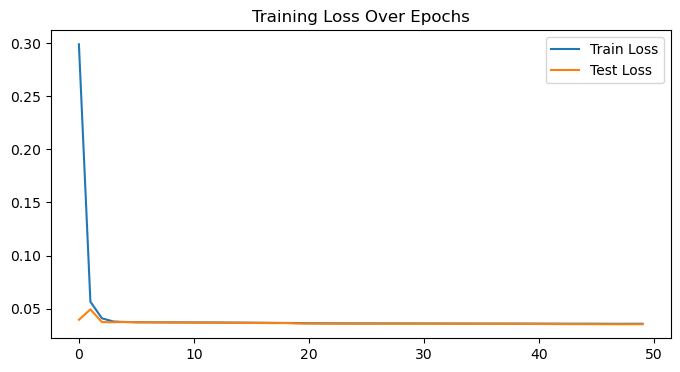

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


ValueError: x and y must have same first dimension, but have shapes (901,) and (900, 1)

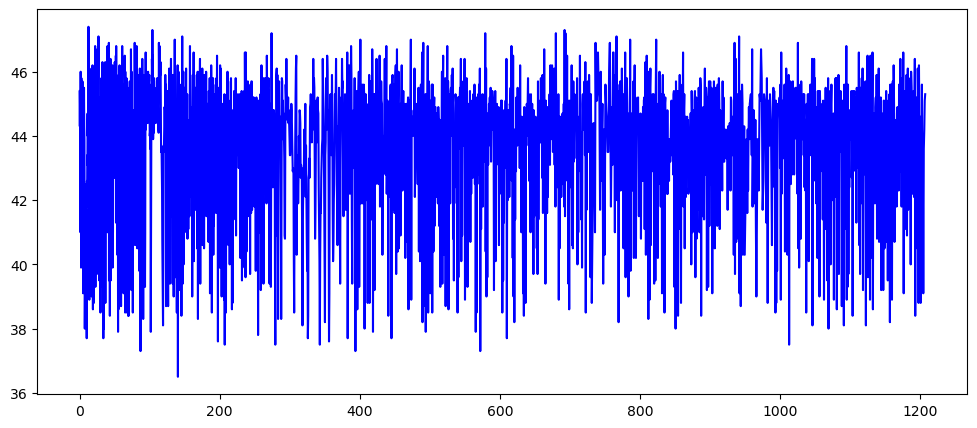

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout

# 🔹 1. Load & Preprocessing Dataset
df = pd.read_csv("yaskawa_train.CSV")

# 🔹 2. Konversi format waktu (000:HH:MM:SS.sss)
def convert_time_format(time_str):
    try:
        parts = time_str.split(":")
        if len(parts) == 4:  # Format dengan hari
            days = int(parts[0])
            hours = int(parts[1])
            minutes = int(parts[2])
            seconds = float(parts[3])
        else:
            days = 0
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
        return days * 86400 + hours * 3600 + minutes * 60 + seconds
    except:
        return None

df["Time"] = df["Time"].astype(str).apply(convert_time_format)
df = df.dropna(subset=["Time"])  # Hapus data yang gagal dikonversi

# 🔹 3. Ambil hanya kolom "Output Power"
data_series = df["Output Power"].values.reshape(-1, 1)

# 🔹 4. Normalisasi data agar stabil untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_series)

# 🔹 5. Plot data asli
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["Output Power"], label="Output Power", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Output Power")
plt.title("Output Power Over Time")
plt.legend()
plt.show()

# 🔹 6. Buat dataset untuk multi-step forecasting
def create_dataset_multi(data, past_steps=2400, future_steps=600):
    X, y = [], []
    total_steps = past_steps + future_steps
    
    if len(data) < total_steps:
        print(f"⚠️ ERROR: Data terlalu sedikit untuk {total_steps} langkah! Coba kurangi `past_steps` atau `future_steps`.")
        return np.array([]), np.array([])
    
    for i in range(len(data) - total_steps):
        X.append(data[i:i+past_steps, 0])
        y.append(data[i+past_steps:i+past_steps+future_steps, 0])
    
    return np.array(X), np.array(y)

# 🔹 Coba lagi dengan dataset baru
X, y = create_dataset_multi(data_scaled, past_steps, future_steps)
print(f"✅ X shape: {X.shape}, y shape: {y.shape}")  # Harus memiliki dimensi


past_steps = 1000  # Gunakan 40 menit terakhir sebagai input
future_steps = 900  # Prediksi 30 menit ke depan
X, y = create_dataset_multi(data_scaled, past_steps, future_steps)

# 🔹 7. Reshape data untuk LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 🔹 8. Split data menjadi training (80%) dan testing (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# 🔹 9. Bangun Model LSTM Encoder-Decoder
model = Sequential([
    LSTM(100, activation='relu', input_shape=(past_steps, 1)),  # Encoder
    RepeatVector(future_steps),  # Repeat output untuk setiap langkah di masa depan
    LSTM(100, activation='relu', return_sequences=True),  # Decoder
    TimeDistributed(Dense(1))  # Output sequence yang diprediksi
])

# 🔹 10. Compile & Train Model
model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 🔹 11. Plot Loss selama Training
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()

# 🔹 12. Prediksi 30 Menit ke Depan
last_sequence = X_test[-1].reshape(1, past_steps, 1)
predictions = model.predict(last_sequence)

# 🔹 13. Denormalisasi hasil prediksi ke skala asli
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# 🔹 14. Buat sumbu waktu untuk prediksi
future_times = np.arange(df["Time"].iloc[-1] + 1, df["Time"].iloc[-1] + future_steps + 1)

# 🔹 15. Plot hasil prediksi
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["Output Power"], label="Actual Data", color="blue")
plt.plot(future_times, predictions, label="LSTM Forecast (30 min ahead)", color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Output Power")
plt.title("LSTM Forecasting Output Power (30 Minutes Ahead)")
plt.legend()
plt.show()
